# FP-CycleGAN → ResNet-18 (Complete) + Per-Class Interpolations
Generated 2025-11-10 12:17:31

- Robust Drive paths
- IMG size = 256 (×32 safe)
- Full metrics and visualizations
- Random per-class interpolation + GAN comparisons saved to `Drive/INTERPOLATION`

In [1]:
# %pip -q install torchinfo scikit-learn tqdm torchvision

In [2]:

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("Drive mounted.")
except Exception as e:
    print("Not in Colab or mount failed:", e)


Mounted at /content/drive
Drive mounted.


In [3]:

import os, random, time, math, glob
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image

import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm

try:
    from torch.cuda.amp import autocast, GradScaler
    AMP_AVAILABLE = True
except Exception:
    AMP_AVAILABLE = False

def find_first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return p
    return None

DRIVE_ROOTS = ["/content/drive/My Drive", "/content/drive/MyDrive"]
DRIVE_ROOT = find_first_existing(DRIVE_ROOTS) or "/content/drive/My Drive"

DATA_CANDIDATES = [
    f"{DRIVE_ROOT}/FPGAN/data",
    "/content/FPGAN/data",
    "./FPGAN/data",
    "./data",
]
DATA_DIR = find_first_existing(DATA_CANDIDATES)
if DATA_DIR is None:
    raise RuntimeError("Dataset path not found. Ensure 'FPGAN/data' exists in Google Drive with domainA/domainB.")

class Cfg:
    DATA_DIR   = DATA_DIR
    A_DIR      = str(Path(DATA_DIR) / "domainA")
    B_DIR      = str(Path(DATA_DIR) / "domainB")
    PROJECT_DIR= str(Path(DATA_DIR).parents[1]) if len(Path(DATA_DIR).parents) >= 2 else "/content"
    OUT_DIR    = str(Path(PROJECT_DIR) / "outputs")
    CKPT_DIR   = str(Path(OUT_DIR) / "checkpoints")
    SAMPLES_DIR= str(Path(OUT_DIR) / "samples")
    LOGS_DIR   = str(Path(OUT_DIR) / "logs")
    CLS_DIR    = str(Path(OUT_DIR) / "classifier")
    INTERP_DIR = str(Path(DRIVE_ROOT) / "INTERPOLATION")

    IMG_SIZE = 256
    IN_CH    = 3

    SEED         = 42
    BATCH        = 8
    EPOCHS_GAN   = 50
    LR_G         = 2e-4
    LR_D         = 2e-4
    BETA1        = 0.5
    BETA2        = 0.999
    AMP          = True
    LAMBDA_CYCLE = 10.0
    LAMBDA_IDT   = 5.0
    MU_BUFFER    = 0.5
    NUM_WORKERS  = 2

    CLS_BATCH  = 32
    EPOCHS_CLS = 20
    LR_CLS     = 1e-3
    VAL_SPLIT  = 0.2

for d in [Cfg.OUT_DIR, Cfg.CKPT_DIR, Cfg.SAMPLES_DIR, Cfg.LOGS_DIR, Cfg.CLS_DIR]:
    os.makedirs(d, exist_ok=True)
os.makedirs(Cfg.INTERP_DIR, exist_ok=True)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

set_seed(Cfg.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("DATA_DIR:", Cfg.DATA_DIR)
print("A_DIR exists:", Path(Cfg.A_DIR).exists(), "B_DIR exists:", Path(Cfg.B_DIR).exists())
print("INTERP_DIR:", Cfg.INTERP_DIR)


Device: cuda
DATA_DIR: /content/drive/My Drive/FPGAN/data
A_DIR exists: True B_DIR exists: True
INTERP_DIR: /content/drive/My Drive/INTERPOLATION


In [4]:

from torchvision import transforms

def make_transform(size):
    return transforms.Compose([
        transforms.Resize((size, size), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])

class FolderSet(Dataset):
    IMG_EXT = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")
    def __init__(self, root, transform=None):
        self.root = Path(root)
        assert self.root.exists(), f"Missing directory: {root}"
        self.transform = transform or make_transform(Cfg.IMG_SIZE)
        self.samples = []
        self.classes = []
        for d in sorted([p for p in self.root.iterdir() if p.is_dir()]):
            cls = d.name
            self.classes.append(cls)
            for f in d.rglob("*"):
                if f.suffix.lower() in self.IMG_EXT:
                    self.samples.append((str(f), cls))
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        print(f"[{self.root.name}] classes:", self.classes, f"(n={len(self.classes)})")
        print(f"[{self.root.name}] images:", len(self.samples))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, cls = self.samples[idx]
        with Image.open(path) as im:
            im = im.convert("RGB")
        x = self.transform(im)
        return x, self.class_to_idx[cls], cls, path

tfm = make_transform(Cfg.IMG_SIZE)
dsA = FolderSet(Cfg.A_DIR, transform=tfm)
dsB = FolderSet(Cfg.B_DIR, transform=tfm)
dlA = DataLoader(dsA, batch_size=Cfg.BATCH, shuffle=True, num_workers=Cfg.NUM_WORKERS, drop_last=True, pin_memory=True)
dlB = DataLoader(dsB, batch_size=Cfg.BATCH, shuffle=True, num_workers=Cfg.NUM_WORKERS, drop_last=True, pin_memory=True)

print("A batches:", len(dlA), "B batches:", len(dlB))


[domainA] classes: ['Noload'] (n=1)
[domainA] images: 582
[domainB] classes: ['A&B50', 'A&C&B10', 'A&C&B30', 'A&C10', 'A&C30', 'A10', 'A30', 'A50', 'Fan', 'Rotor-0'] (n=10)
[domainB] images: 5820
A batches: 72 B batches: 727


In [5]:

import re
PHASES = ("A","B","C")
def parse_class_name(name: str):
    s=name.strip(); low=s.lower()
    if low=="fan": return {"type":"fan","phases":(),"severity":None,"raw":s}
    if low=="noload": return {"type":"noload","phases":(),"severity":None,"raw":s}
    if low.startswith("rotor"):
        m=re.search(r"rotor[-_]?(\d+)", low); sev=int(m.group(1)) if m else None; return {"type":"rotor","phases":(),"severity":sev,"raw":s}
    m=re.match(r"^([ABC](?:&[ABC])*)(\d+)?$", s, flags=re.I)
    if m:
        phases=tuple([p for p in m.group(1).upper().split("&") if p in PHASES])
        sev=int(m.group(2)) if m.group(2) else None; return {"type":"phase_fault","phases":phases,"severity":sev,"raw":s}
    return {"type":"unknown","phases":(),"severity":None,"raw":s}
def _sort_key(info):
    type_order={"noload":0,"fan":1,"rotor":2,"phase_fault":3,"unknown":9}
    t=type_order.get(info["type"],9); nph=len(info["phases"]); phase_tuple=info["phases"]; sev=info["severity"] if info["severity"] is not None else 10**9
    return (t,nph,phase_tuple,sev,info["raw"].lower())
CLASS_NAMES = sorted(list(set(dsB.classes + (["Noload"] if "Noload" in dsA.classes and "Noload" not in dsB.classes else []))), key=lambda n:_sort_key(parse_class_name(n)))
label2id={c:i for i,c in enumerate(CLASS_NAMES)}; id2label={i:c for c,i in label2id.items()}
print("CLASS_NAMES:", CLASS_NAMES)
HEALTHY_NAMES={"Noload"}
def is_healthy(name:str)->bool: return name in HEALTHY_NAMES


CLASS_NAMES: ['Noload', 'Fan', 'Rotor-0', 'A10', 'A30', 'A50', 'A&B50', 'A&C10', 'A&C30', 'A&C&B10', 'A&C&B30']


In [6]:

class SepConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__(); self.depth=nn.Conv2d(in_ch,in_ch,k,s,p,groups=in_ch,bias=False); self.point=nn.Conv2d(in_ch,out_ch,1,1,0,bias=False); self.norm=nn.LayerNorm(out_ch); self.act=nn.GELU()
    def forward(self,x): x=self.depth(x); x=self.point(x); x=x.permute(0,2,3,1); x=self.norm(x); x=x.permute(0,3,1,2); return self.act(x)
class CNBlock(nn.Module):
    def __init__(self,ch,drop_path=0.0,layer_scale=1.0):
        super().__init__(); self.dw=nn.Conv2d(ch,ch,7,1,3,groups=ch); self.norm=nn.LayerNorm(ch); self.pw1=nn.Conv2d(ch,4*ch,1); self.act=nn.GELU(); self.pw2=nn.Conv2d(4*ch,ch,1); self.gamma=nn.Parameter(layer_scale*torch.ones((ch)),requires_grad=True); self.drop_path=nn.Dropout(drop_path) if drop_path>0 else nn.Identity()
    def forward(self,x): s=x; x=self.dw(x); x=x.permute(0,2,3,1); x=self.norm(x); x=x.permute(0,3,1,2); x=self.pw1(x); x=self.act(x); x=self.pw2(x); x=x*self.gamma.view(1,-1,1,1); x=self.drop_path(x); return x+s
def upsample_bicubic(x,scale_factor=2): return F.interpolate(x,scale_factor=scale_factor,mode='bicubic',align_corners=False)
class UpBlock(nn.Module):
    def __init__(self,in_ch,skip_ch,out_ch): super().__init__(); self.conv1=SepConv(in_ch+skip_ch,out_ch); self.conv2=SepConv(out_ch,out_ch)
    def forward(self,x,skip): x=upsample_bicubic(x,2); x=torch.cat([x,skip],1); x=self.conv1(x); x=self.conv2(x); return x
class GeneratorUNet(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dims=(96,192,384,768)):
        super().__init__(); self.stem=nn.Conv2d(in_ch,dims[0],4,4,0); self.down1=nn.Sequential(CNBlock(dims[0]),CNBlock(dims[0]),nn.Conv2d(dims[0],dims[1],2,2)); self.down2=nn.Sequential(CNBlock(dims[1]),CNBlock(dims[1]),nn.Conv2d(dims[1],dims[2],2,2)); self.down3=nn.Sequential(CNBlock(dims[2]),nn.Conv2d(dims[2],dims[3],2,2)); self.bot=nn.Sequential(CNBlock(dims[3]),CNBlock(dims[3]),CNBlock(dims[3])); self.up1=UpBlock(dims[3],dims[2],dims[2]); self.up2=UpBlock(dims[2],dims[1],dims[1]); self.up3=UpBlock(dims[1],dims[0],dims[0]); self.to_rgb=nn.Sequential(nn.ConvTranspose2d(dims[0],out_ch,4,4,0),nn.Tanh())
    def forward(self,x): s0=self.stem(x); s1=self.down1(s0); s2=self.down2(s1); s3=self.down3(s2); b=self.bot(s3); u1=self.up1(b,s2); u2=self.up2(u1,s1); u3=self.up3(u2,s0); return self.to_rgb(u3)
class PatchDiscriminator(nn.Module):
    def __init__(self,ch=64,in_ch=3):
        super().__init__();
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,ch,4,2,1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ch,ch*2,4,2,1), nn.InstanceNorm2d(ch*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ch*2,ch*4,4,2,1), nn.InstanceNorm2d(ch*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ch*4,ch*8,4,1,1), nn.InstanceNorm2d(ch*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ch*8,1,4,1,1)
        )
    def forward(self,x): return self.net(x)
class D_AB_Classifier(nn.Module):
    def __init__(self,in_ch=3,base=64):
        super().__init__(); self.body=nn.Sequential(nn.Conv2d(in_ch,base,4,2,1),nn.LeakyReLU(0.2,True),nn.Conv2d(base,base*2,4,2,1),nn.BatchNorm2d(base*2),nn.LeakyReLU(0.2,True),nn.Conv2d(base*2,base*4,4,2,1),nn.BatchNorm2d(base*4),nn.LeakyReLU(0.2,True),nn.Conv2d(base*4,base*8,4,2,1),nn.BatchNorm2d(base*8),nn.LeakyReLU(0.2,True)); self.head=nn.Sequential(nn.AdaptiveAvgPool2d(1),nn.Flatten(),nn.Linear(base*8,2))
    def forward(self,x): return self.head(self.body(x))


In [7]:

G_AB = GeneratorUNet(Cfg.IN_CH, Cfg.IN_CH).to(device)
G_BA = GeneratorUNet(Cfg.IN_CH, Cfg.IN_CH).to(device)
D_A  = PatchDiscriminator(in_ch=Cfg.IN_CH).to(device)
D_B  = PatchDiscriminator(in_ch=Cfg.IN_CH).to(device)
D_AB = D_AB_Classifier(in_ch=Cfg.IN_CH).to(device)

opt_G  = optim.Adam(list(G_AB.parameters())+list(G_BA.parameters()), lr=Cfg.LR_G, betas=(Cfg.BETA1, Cfg.BETA2))
opt_DA = optim.Adam(D_A.parameters(), lr=Cfg.LR_D, betas=(Cfg.BETA1, Cfg.BETA2))
opt_DB = optim.Adam(D_B.parameters(), lr=Cfg.LR_D, betas=(Cfg.BETA1, Cfg.BETA2))
opt_DAB= optim.Adam(D_AB.parameters(), lr=Cfg.LR_D, betas=(Cfg.BETA1, Cfg.BETA2))

mse = nn.MSELoss(); l1 = nn.L1Loss(); ce = nn.CrossEntropyLoss()

class ImageBuffer:
    def __init__(self,max_size=50): self.max_size=max_size; self.data=[]
    def push_and_pop(self,tensors):
        import random
        out=[]
        for t in tensors:
            t=t.detach()
            if len(self.data)<self.max_size: self.data.append(t); out.append(t)
            else:
                if random.random()>0.5:
                    idx=random.randint(0,self.max_size-1); tmp=self.data[idx].clone(); self.data[idx]=t; out.append(tmp)
                else: out.append(t)
        return torch.stack(out,0)
buf_A=ImageBuffer(50); buf_B=ImageBuffer(50)
from torch.cuda.amp import GradScaler
scaler = GradScaler(enabled=True)

class TrainMonitor:
    def __init__(self): self.losses={}
    def log(self,k,v): self.losses.setdefault(k,[]).append(float(v))
monitor=TrainMonitor()

def denorm(t): return (t*0.5+0.5).clamp(0,1)
def save_grid(path,*tensors,ncols=4):
    from torchvision.utils import save_image
    arrs=[denorm(x.detach().cpu()) for x in tensors]
    x=torch.cat(arrs,0); B,C,H,W=x.size(0),x.size(1),x.size(2),x.size(3)
    nrows=(B+ncols-1)//ncols; grid=torch.ones(C,nrows*H,ncols*W)
    for i in range(B):
        r,c=divmod(i,ncols); grid[:, r*H:(r+1)*H, c*W:(c+1)*W]=x[i]
    Path(path).parent.mkdir(parents=True, exist_ok=True); save_image(grid, path)

import matplotlib.pyplot as plt
def plot_loss_curves(monitor, keys=("G_total","D_A","D_B","D_AB"), savepath=None):
    fig=plt.figure()
    for k in keys:
        if k in monitor.losses: plt.plot(monitor.losses[k], label=k)
    plt.legend(); plt.xlabel("Iterations"); plt.ylabel("Loss"); plt.title("Loss Curves")
    if savepath: Path(savepath).parent.mkdir(parents=True, exist_ok=True); plt.savefig(savepath, dpi=200, bbox_inches='tight');
    plt.show()

def train_epoch(epoch, dlA, dlB):
    G_AB.train(); G_BA.train(); D_A.train(); D_B.train(); D_AB.train()
    iters=min(len(dlA),len(dlB)); loopA=iter(dlA); loopB=iter(dlB)
    with torch.no_grad():
        dummy=torch.randn(Cfg.BATCH, Cfg.IN_CH, Cfg.IMG_SIZE, Cfg.IMG_SIZE, device=device); shape=D_A(dummy).shape
    valid=torch.ones(shape, device=device); fakev=torch.zeros(shape, device=device)
    for it in tqdm(range(iters), desc=f"Epoch {epoch}"):
        realA,_,_,_=next(loopA); realB,_,_,_ = next(loopB)
        realA=realA.to(device,non_blocking=True); realB=realB.to(device,non_blocking=True)

        opt_G.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=True):
            fakeB=G_AB(realA); fakeA=G_BA(realB)
            recA=G_BA(fakeB);  recB=G_AB(fakeA)
            idtA=G_BA(realA);  idtB=G_AB(realB)
            loss_GAN_AB=mse(D_B(fakeB), valid); loss_GAN_BA=mse(D_A(fakeA), valid)
            loss_cycle=l1(recA,realA)+l1(recB,realB); loss_idt=l1(idtA,realA)+l1(idtB,realB)
            bsz=realA.size(0); n_real=int(Cfg.MU_BUFFER*bsz)
            idxA=torch.randperm(bsz, device=device)[:n_real]; idxB=torch.randperm(bsz, device=device)[:n_real]
            newA=torch.cat([realA[idxA], buf_A.push_and_pop(fakeA.detach().cpu())[:bsz-n_real].to(device)],0)
            newB=torch.cat([realB[idxB], buf_B.push_and_pop(fakeB.detach().cpu())[:bsz-n_real].to(device)],0)
            logits_A=D_AB(newA); logits_B=D_AB(newB)
            loss_class=ce(logits_A, torch.zeros(logits_A.size(0), dtype=torch.long, device=device)) + ce(logits_B, torch.ones(logits_B.size(0), dtype=torch.long, device=device))
            loss_G=loss_GAN_AB+loss_GAN_BA+Cfg.LAMBDA_CYCLE*loss_cycle+Cfg.LAMBDA_IDT*loss_idt+loss_class
        scaler.scale(loss_G).backward(); scaler.step(opt_G); scaler.update(); monitor.log("G_total", loss_G.item())

        opt_DA.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=True):
            loss_DA=0.5*(mse(D_A(realA), valid)+mse(D_A(fakeA.detach()), fakev))
        scaler.scale(loss_DA).backward(); scaler.step(opt_DA); scaler.update(); monitor.log("D_A", loss_DA.item())

        opt_DB.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=True):
            loss_DB=0.5*(mse(D_B(realB), valid)+mse(D_B(fakeB.detach()), fakev))
        scaler.scale(loss_DB).backward(); scaler.step(opt_DB); scaler.update(); monitor.log("D_B", loss_DB.item())

        opt_DAB.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=True):
            logits_A=D_AB(newA.detach()); logits_B=D_AB(newB.detach())
            loss_DAB=ce(logits_A, torch.zeros(logits_A.size(0), dtype=torch.long, device=device)) + ce(logits_B, torch.ones(logits_B.size(0), dtype=torch.long, device=device))
        scaler.scale(loss_DAB).backward(); scaler.step(opt_DAB); scaler.update(); monitor.log("D_AB", loss_DAB.item())

        if it % 100 == 0:
            save_grid(str(Path(Cfg.SAMPLES_DIR)/f"e{epoch:03d}_i{it:05d}.png"), realA[:4], fakeB[:4], recA[:4], realB[:4], fakeA[:4], recB[:4])


/tmp/ipython-input-1926135716.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)


Epoch 1:   0%|          | 0/72 [00:00<?, ?it/s]/tmp/ipython-input-1926135716.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/tmp/ipython-input-1926135716.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/tmp/ipython-input-1926135716.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/tmp/ipython-input-1926135716.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
Epoch 5: 100%|██████████| 72/72 [01:26<00:00,  1.20s/it]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e005.pt


Epoch 10: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e010.pt


Epoch 15: 100%|██████████| 72/72 [00:56<00:00,  1.28it/s]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e015.pt


Epoch 20: 100%|██████████| 72/72 [00:54<00:00,  1.32it/s]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e020.pt


Epoch 25: 100%|██████████| 72/72 [00:54<00:00,  1.31it/s]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e025.pt


Epoch 30: 100%|██████████| 72/72 [00:54<00:00,  1.33it/s]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e030.pt


Epoch 35: 100%|██████████| 72/72 [00:54<00:00,  1.31it/s]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e035.pt


Epoch 40: 100%|██████████| 72/72 [00:54<00:00,  1.32it/s]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e040.pt


Epoch 45: 100%|██████████| 72/72 [00:54<00:00,  1.32it/s]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e045.pt


Epoch 50: 100%|██████████| 72/72 [00:54<00:00,  1.32it/s]


Saved: /content/drive/My Drive/outputs/checkpoints/fpgan_e050.pt


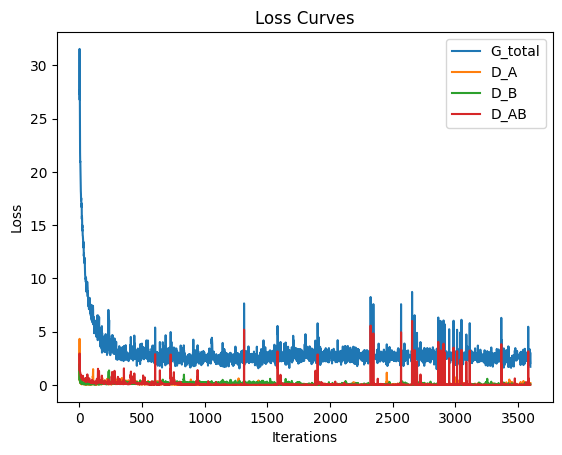

GAN training done.


In [8]:

for epoch in range(1, Cfg.EPOCHS_GAN+1):
    train_epoch(epoch, dlA, dlB)
    if epoch % 5 == 0 or epoch == Cfg.EPOCHS_GAN:
        payload={"epoch":epoch,"G_AB":G_AB.state_dict(),"G_BA":G_BA.state_dict(),"D_A":D_A.state_dict(),"D_B":D_B.state_dict(),"D_AB":D_AB.state_dict()}
        p=str(Path(Cfg.CKPT_DIR)/f"fpgan_e{epoch:03d}.pt"); torch.save(payload,p); print("Saved:",p)
plot_loss_curves(monitor, savepath=str(Path(Cfg.LOGS_DIR)/"loss_curves_gan.png"))
print("GAN training done.")


In [9]:

from torchvision import models
def adapt_classifier(model: nn.Module, n_classes: int):
    if hasattr(model,'fc') and isinstance(model.fc, nn.Linear):
        model.fc = nn.Linear(model.fc.in_features, n_classes); print("Replaced .fc ->", n_classes)
    else:
        last=None; name=None
        for nm,m in model.named_modules():
            if isinstance(m, nn.Linear): last, name = m, nm
        if last is not None:
            parent=model; parts=name.split('.')[:-1]; leaf=name.split('.')[-1]
            for p in parts: parent=getattr(parent,p)
            setattr(parent, leaf, nn.Linear(last.in_features, n_classes)); print(f"Replaced {name} -> {n_classes}")
    return model

def probe_io(model, input_shape=(3, Cfg.IMG_SIZE, Cfg.IMG_SIZE)):
    x=torch.randn(1,*input_shape).to(device); model=model.to(device).eval()
    with torch.no_grad(): y=model(x)
    print("Input:",tuple(x.shape),"-> Output:",tuple(y.shape) if hasattr(y,'shape') else type(y)); return x,y

def model_summary(model, input_size=(3, Cfg.IMG_SIZE, Cfg.IMG_SIZE)):
    try:
        from torchinfo import summary
        return summary(model.to(device), input_size=(1,*input_size))
    except Exception as e:
        print("torchinfo not available. Params:", sum(p.numel() for p in model.parameters()))

def save_hparam_table(table_path, **hparams):
    import pandas as pd
    rows=[{"Hyperparameter":k,"Value":v} for k,v in hparams.items()]
    df=pd.DataFrame(rows); Path(table_path).parent.mkdir(parents=True, exist_ok=True); df.to_csv(table_path, index=False); print("Saved:",table_path); return df

save_hparam_table(str(Path(Cfg.LOGS_DIR)/"table2_hparams.csv"),
    img_size=Cfg.IMG_SIZE, batch_gan=Cfg.BATCH, epochs_gan=Cfg.EPOCHS_GAN, lr_g=Cfg.LR_G, lr_d=Cfg.LR_D,
    lambda_cycle=Cfg.LAMBDA_CYCLE, lambda_idt=Cfg.LAMBDA_IDT, mu_buffer=Cfg.MU_BUFFER, amp=Cfg.AMP,
    classes="|".join(CLASS_NAMES), n_classes=len(CLASS_NAMES))


Saved: /content/drive/My Drive/outputs/logs/table2_hparams.csv


,Hyperparameter,Value
0,img_size,256
1,batch_gan,8
2,epochs_gan,50
3,lr_g,0.0002
4,lr_d,0.0002
5,lambda_cycle,10.0
6,lambda_idt,5.0
7,mu_buffer,0.5
8,amp,True
9,classes,Noload|Fan|Rotor-0|A10|A30|A50|A&B50|A&C10|A&C...


In [10]:

class ClassifierFolderSet(Dataset):
    def __init__(self, roots: List[Path], transform=None):
        self.transform=transform or make_transform(Cfg.IMG_SIZE)
        self.samples=[]; kept=set(CLASS_NAMES)
        for root in roots:
            root=Path(root)
            if not root.exists(): continue
            for d in sorted([p for p in root.iterdir() if p.is_dir()]):
                cls=d.name
                if cls not in kept: continue
                for f in d.rglob("*"):
                    if f.suffix.lower() in FolderSet.IMG_EXT: self.samples.append((str(f), cls))
        random.shuffle(self.samples); self.label2id={c:i for i,c in enumerate(CLASS_NAMES)}
        print("Classifier samples:", len(self.samples), "classes:", CLASS_NAMES)
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, cls = self.samples[idx]; im=Image.open(path).convert("RGB"); x=self.transform(im); y=self.label2id[cls]; return x,y,cls,path

cls_ds = ClassifierFolderSet([Path(Cfg.B_DIR), Path(Cfg.A_DIR)], transform=make_transform(Cfg.IMG_SIZE))
val_len = max(1, int(len(cls_ds)*Cfg.VAL_SPLIT)); train_len = max(1, len(cls_ds)-val_len)
cls_train, cls_val = random_split(cls_ds, [train_len, val_len], generator=torch.Generator().manual_seed(Cfg.SEED))

dl_train = DataLoader(cls_train, batch_size=Cfg.CLS_BATCH, shuffle=True,  num_workers=Cfg.NUM_WORKERS, pin_memory=True)
dl_val   = DataLoader(cls_val,   batch_size=Cfg.CLS_BATCH, shuffle=False, num_workers=Cfg.NUM_WORKERS, pin_memory=True)

from torchvision import models
clf = models.resnet18(weights=None)
clf = adapt_classifier(clf, n_classes=len(CLASS_NAMES))
probe_io(clf); model_summary(clf)

criterion = nn.CrossEntropyLoss(); optimizer = optim.Adam(clf.parameters(), lr=Cfg.LR_CLS)
best_val_acc, best_path = 0.0, str(Path(Cfg.CLS_DIR)/"best_resnet18.pt")

def evaluate(model, loader):
    model.eval(); correct=0; total=0; losses=[]
    with torch.no_grad():
        for xb, yb, cls, p in loader:
            xb=xb.to(device); yb=yb.to(device)
            out=model(xb); loss=criterion(out,yb); pred=out.argmax(-1)
            correct += (pred==yb).sum().item(); total += yb.numel(); losses.append(loss.item())
    return correct/max(total,1), float(np.mean(losses)) if losses else 0.0

clf = clf.to(device)
for ep in range(1, Cfg.EPOCHS_CLS+1):
    clf.train(); running=0.0; n=0
    for xb, yb, cls, p in dl_train:
        xb=xb.to(device); yb=yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        out=clf(xb); loss=criterion(out,yb); loss.backward(); optimizer.step()
        running += loss.item()*yb.size(0); n += yb.size(0)
    tr_loss = running/max(n,1)
    val_acc, val_loss = evaluate(clf, dl_val)
    print(f"[{ep:03d}] train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc; torch.save({"model": clf.state_dict(), "classes": CLASS_NAMES}, best_path); print("  ↳ saved best:", best_path)
print("Classifier training done. Best val acc:", best_val_acc)


Classifier samples: 6402 classes: ['Noload', 'Fan', 'Rotor-0', 'A10', 'A30', 'A50', 'A&B50', 'A&C10', 'A&C30', 'A&C&B10', 'A&C&B30']
Replaced .fc -> 11
Input: (1, 3, 256, 256) -> Output: (1, 11)
torchinfo not available. Params: 11182155
[001] train_loss=0.5913  val_loss=6.2805  val_acc=0.2211
  ↳ saved best: /content/drive/My Drive/outputs/classifier/best_resnet18.pt
[002] train_loss=0.5307  val_loss=2.7043  val_acc=0.4656
  ↳ saved best: /content/drive/My Drive/outputs/classifier/best_resnet18.pt
[003] train_loss=0.4123  val_loss=0.5531  val_acc=0.7734
  ↳ saved best: /content/drive/My Drive/outputs/classifier/best_resnet18.pt
[004] train_loss=0.3454  val_loss=2.2179  val_acc=0.5852
[005] train_loss=0.3491  val_loss=0.2068  val_acc=0.9086
  ↳ saved best: /content/drive/My Drive/outputs/classifier/best_resnet18.pt
[006] train_loss=0.2743  val_loss=4.7160  val_acc=0.3469
[007] train_loss=0.2414  val_loss=0.6355  val_acc=0.7766
[008] train_loss=0.2094  val_loss=0.2137  val_acc=0.9000
[00

Loading classifier from: /content/drive/My Drive/outputs/classifier/best_resnet18.pt
Replaced .fc -> 11


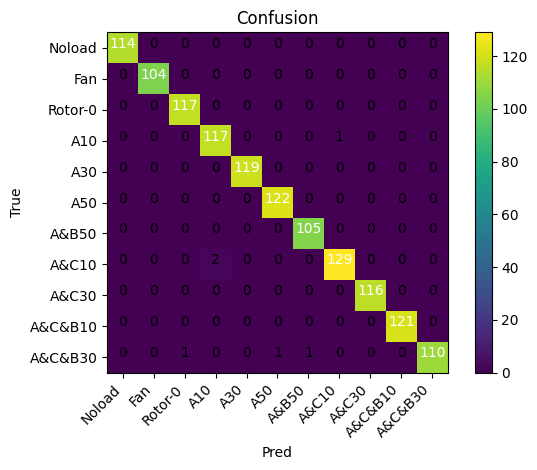

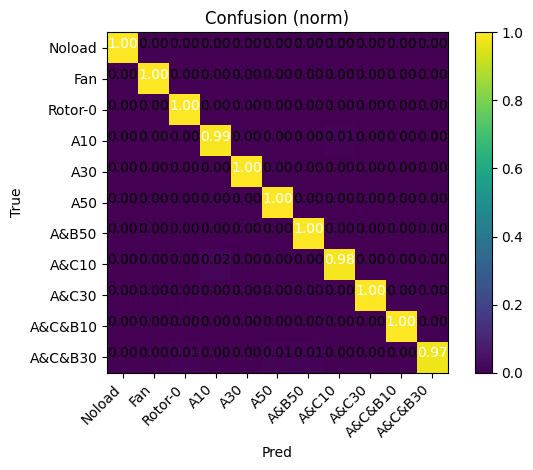

      class  precision    recall        f1  support
0    Noload   1.000000  1.000000  1.000000      114
1       Fan   1.000000  1.000000  1.000000      104
2   Rotor-0   0.991525  1.000000  0.995745      117
3       A10   0.983193  0.991525  0.987342      118
4       A30   1.000000  1.000000  1.000000      119
5       A50   0.991870  1.000000  0.995918      122
6     A&B50   0.990566  1.000000  0.995261      105
7     A&C10   0.992308  0.984733  0.988506      131
8     A&C30   1.000000  1.000000  1.000000      116
9   A&C&B10   1.000000  1.000000  1.000000      121
10  A&C&B30   1.000000  0.973451  0.986547      113
Macro: {'precision': 0.9954056681620425, 'recall': 0.9954281432354475, 'f1': 0.9953925741986581, 'support': 1280}
Micro: {'precision': 0.9953125, 'recall': 0.9953125, 'f1': 0.9953125, 'support': 1280}
Weighted: {'precision': 0.9953399633084633, 'recall': 0.9953125, 'f1': 0.9953022974683104, 'support': 1280}


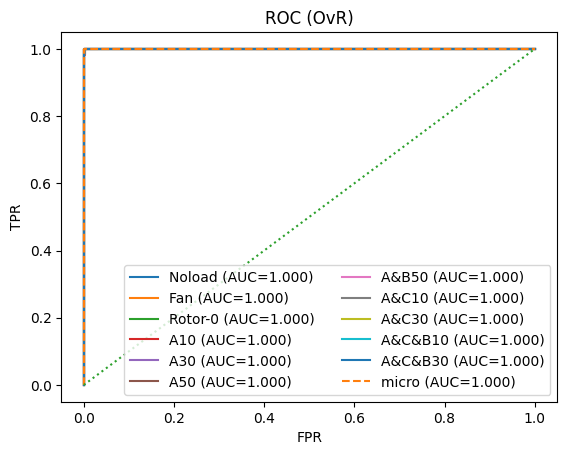

Binary confusion
 [[ 114    0]
 [   0 1166]]


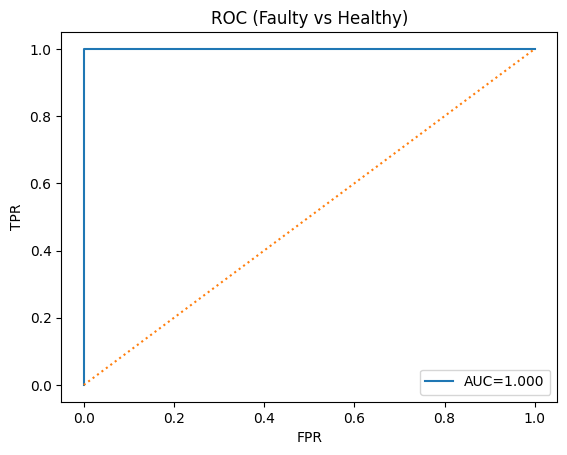

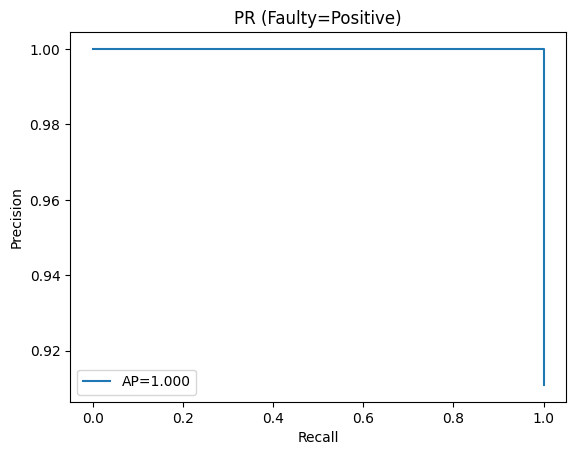

In [11]:

from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_fscore_support, average_precision_score, precision_recall_curve)
import numpy as np, matplotlib.pyplot as plt

best_ckpt_candidates = [
    str(Path(Cfg.CLS_DIR) / "best_resnet18.pt"),
    str(Path(DRIVE_ROOT) / "best_resnet18.pt"),
]
best_ckpt = next((p for p in best_ckpt_candidates if Path(p).exists()), None)
if best_ckpt:
    print("Loading classifier from:", best_ckpt)
    state = torch.load(best_ckpt, map_location=device)
    try:
        from torchvision import models
        clf = models.resnet18(weights=None)
        clf = adapt_classifier(clf, n_classes=len(CLASS_NAMES))
        clf.load_state_dict(state["model"], strict=False)
        clf = clf.to(device).eval()
    except Exception as e:
        print("Warning: failed to restore clf; using in-memory model.", e)

def collect_predictions(model, loader, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval(); ys_true, ys_pred, ys_score = [], [], []
    with torch.no_grad():
        for xb, yb, cls, p in loader:
            xb=xb.to(device); out=model(xb); probs=torch.softmax(out, dim=-1)
            ys_true.append(yb.cpu().numpy()); ys_pred.append(probs.argmax(-1).cpu().numpy()); ys_score.append(probs.cpu().numpy())
    y_true=np.concatenate(ys_true,0); y_pred=np.concatenate(ys_pred,0); y_score=np.concatenate(ys_score,0); return y_true, y_pred, y_score

def plot_confusion(y_true, y_pred, class_names=None, normalize=False, title=None, savepath=None):
    cm = confusion_matrix(y_true, y_pred)
    if normalize: cm = cm.astype('float')/(cm.sum(axis=1, keepdims=True)+1e-12)
    fig=plt.figure(); plt.imshow(cm, interpolation='nearest'); plt.title(title or ('Confusion (norm)' if normalize else 'Confusion')); plt.colorbar()
    ticks=np.arange(cm.shape[0]); names=class_names or [str(i) for i in range(cm.shape[0])]
    plt.xticks(ticks, names, rotation=45, ha='right'); plt.yticks(ticks, names)
    fmt='.2f' if normalize else 'd'; thr=cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): plt.text(j,i, format(cm[i,j],fmt), ha='center', color='white' if cm[i,j]>thr else 'black')
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout()
    if savepath: Path(savepath).parent.mkdir(parents=True, exist_ok=True); plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

def prf1(y_true, y_pred, average=None, class_names=None, savepath=None):
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=0)
    if average is None:
        import pandas as pd
        if class_names is None: class_names=[str(c) for c in sorted(np.unique(y_true))]
        df=pd.DataFrame({'class':class_names,'precision':p,'recall':r,'f1':f1,'support':s})
        if savepath: Path(savepath).parent.mkdir(parents=True, exist_ok=True); df.to_csv(savepath, index=False)
        return df
    else:
        support_total = int(len(y_true)) if y_true is not None else None
        return {'precision':float(p),'recall':float(r),'f1':float(f1),'support':support_total}

def plot_roc_multiclass(y_true, y_score, class_names=None, savepath=None):
    n=y_score.shape[1]; names=class_names or [str(i) for i in range(n)]
    y_true_bin=np.zeros_like(y_score);
    for i,t in enumerate(y_true): y_true_bin[i,t]=1
    fpr,tpr,roc_auc={}, {}, {}
    fig=plt.figure()
    for i in range(n):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:,i], y_score[:,i]); roc_auc[i]=auc(fpr[i],tpr[i]); plt.plot(fpr[i],tpr[i], label=f"{names[i]} (AUC={roc_auc[i]:.3f})")
    fpr['micro'], tpr['micro'], _ = roc_curve(y_true_bin.ravel(), y_score.ravel()); roc_auc['micro']=auc(fpr['micro'],tpr['micro'])
    plt.plot(fpr['micro'], tpr['micro'], linestyle='--', label=f"micro (AUC={roc_auc['micro']:.3f})")
    plt.plot([0,1],[0,1], linestyle=':'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (OvR)'); plt.legend(loc='lower right', ncol=2)
    if savepath: Path(savepath).parent.mkdir(parents=True, exist_ok=True); plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

def to_binary(y_true, y_pred=None, y_score=None, class_names=None):
    assert class_names is not None
    c2b={i:(0 if id2label[i] in HEALTHY_NAMES else 1) for i in range(len(class_names))}
    y_true_b=np.vectorize(lambda k: c2b[int(k)])(y_true)
    y_pred_b=np.vectorize(lambda k: c2b[int(k)])(y_pred) if y_pred is not None else None
    y_score_b=None
    if y_score is not None:
        healthy=[i for i,n in enumerate(class_names) if n in HEALTHY_NAMES]
        if healthy: y_score_b=1.0 - y_score[:, healthy].sum(axis=1)
        else: y_score_b=np.ones(len(y_true_b), dtype=float)
    return y_true_b, y_pred_b, y_score_b

def plot_roc_binary(y_true_b, y_score_b, savepath=None):
    fpr,tpr,_=roc_curve(y_true_b, y_score_b); A=auc(fpr,tpr)
    fig=plt.figure(); plt.plot(fpr,tpr,label=f"AUC={A:.3f}"); plt.plot([0,1],[0,1],linestyle=':')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Faulty vs Healthy)"); plt.legend()
    if savepath: Path(savepath).parent.mkdir(parents=True, exist_ok=True); plt.savefig(savepath, dpi=200, bbox_inches='tight');
    plt.show()

def plot_pr_binary(y_true_b, y_score_b, savepath=None):
    pr, rc, _ = precision_recall_curve(y_true_b, y_score_b); ap = average_precision_score(y_true_b, y_score_b)
    fig=plt.figure(); plt.plot(rc, pr, label=f"AP={ap:.3f}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (Faulty=Positive)"); plt.legend()
    if savepath: Path(savepath).parent.mkdir(parents=True, exist_ok=True); plt.savefig(savepath, dpi=200, bbox_inches='tight');
    plt.show()

y_true, y_pred, y_score = collect_predictions(clf, dl_val, device=device)
plot_confusion(y_true, y_pred, class_names=CLASS_NAMES, normalize=False, savepath=str(Path(Cfg.LOGS_DIR)/"confusion_val.png"))
plot_confusion(y_true, y_pred, class_names=CLASS_NAMES, normalize=True,  savepath=str(Path(Cfg.LOGS_DIR)/"confusion_val_norm.png"))
df_prf1 = prf1(y_true, y_pred, average=None, class_names=CLASS_NAMES, savepath=str(Path(Cfg.LOGS_DIR)/"per_class_prf1.csv"))
print(df_prf1)
print("Macro:", prf1(y_true, y_pred, average="macro"))
print("Micro:", prf1(y_true, y_pred, average="micro"))
print("Weighted:", prf1(y_true, y_pred, average="weighted"))
plot_roc_multiclass(y_true, y_score, class_names=CLASS_NAMES, savepath=str(Path(Cfg.LOGS_DIR)/"roc_multiclass.png"))
y_true_b, y_pred_b, y_score_b = to_binary(y_true, y_pred, y_score, class_names=CLASS_NAMES)
from sklearn.metrics import confusion_matrix
cm_bin = confusion_matrix(y_true_b, y_pred_b, labels=[0,1]); print("Binary confusion\n", cm_bin)
plot_roc_binary(y_true_b, y_score_b, savepath=str(Path(Cfg.LOGS_DIR)/"roc_binary.png"))
plot_pr_binary(y_true_b, y_score_b, savepath=str(Path(Cfg.LOGS_DIR)/"pr_binary.png"))


In [12]:

from PIL import Image
_PIL_INTERP = {"NEAREST": Image.NEAREST, "BILINEAR": Image.BILINEAR, "BICUBIC": Image.BICUBIC, "LANCZOS": Image.LANCZOS}

def pil_to_tensor(im):
    t = transforms.ToTensor()(im)
    t = transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])(t)
    return t.unsqueeze(0).to(device)

def tensor_to_pil(t):
    t = t.detach().cpu().clamp(-1,1)
    t = (t*0.5+0.5).clamp(0,1)
    t = t.squeeze(0)
    return transforms.ToPILImage()(t)

def safe_resize(im, size=(Cfg.IMG_SIZE, Cfg.IMG_SIZE), mode=Image.BICUBIC):
    return im.resize(size, mode)

def grid_of_images(images, titles=None, savepath=None):
    import matplotlib.pyplot as plt, math
    n = len(images); cols = 3; rows = math.ceil(n/cols)
    fig = plt.figure(figsize=(cols*4, rows*4))
    for i, im in enumerate(images, 1):
        plt.subplot(rows, cols, i); plt.imshow(im); plt.axis('off')
        if titles and i-1 < len(titles): plt.title(titles[i-1])
    if savepath:
        Path(savepath).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.close(fig)

def random_per_class_interpolations(N=5):
    files_by_class = {}
    for root in [Cfg.A_DIR, Cfg.B_DIR]:
        for d in sorted([p for p in Path(root).iterdir() if p.is_dir()]):
            cls = d.name
            files_by_class.setdefault(cls, [])
            for f in d.rglob("*"):
                if f.suffix.lower() in FolderSet.IMG_EXT:
                    files_by_class[cls].append(str(f))
    rng = random.Random(Cfg.SEED)
    print(f"Will process {len(files_by_class)} classes -> {Cfg.INTERP_DIR}")
    for cls, paths in files_by_class.items():
        if not paths: continue
        cls_dir = Path(Cfg.INTERP_DIR) / cls
        cls_dir.mkdir(parents=True, exist_ok=True)
        pick = [paths[i] for i in rng.sample(range(len(paths)), k=min(N, len(paths)))]
        for idx, pth in enumerate(pick, 1):
            try:
                im = Image.open(pth).convert("RGB")
                im = safe_resize(im, (Cfg.IMG_SIZE, Cfg.IMG_SIZE), Image.BICUBIC)

                ims = [(name, safe_resize(im, (Cfg.IMG_SIZE, Cfg.IMG_SIZE), mode)) for name, mode in _PIL_INTERP.items()]
                grid_path = cls_dir / f"{cls}_interp_{idx:02d}.png"
                grid_of_images([im] + [x[1] for x in ims],
                               titles=["ORIG"] + [n for n,_ in ims],
                               savepath=str(grid_path))

                x = pil_to_tensor(im)
                if cls.lower() == "noload":
                    with torch.no_grad():
                        y = G_AB(x)  # A->B
                    y_im = tensor_to_pil(y)
                    ba_path = cls_dir / f"{cls}_AtoB_{idx:02d}.png"
                    grid_of_images([im, y_im], titles=["Before (A)", "After G_AB (B-like)"], savepath=str(ba_path))
                else:
                    with torch.no_grad():
                        y = G_BA(x)  # B->A
                    y_im = tensor_to_pil(y)
                    ab_path = cls_dir / f"{cls}_BtoA_{idx:02d}.png"
                    grid_of_images([im, y_im], titles=["Before (B)", "After G_BA (A-like)"], savepath=str(ab_path))
            except Exception as e:
                print(f"[warn] GAN or interpolation failed on {pth}: {e}")

# Example: random_per_class_interpolations(N=5)


In [13]:
random_per_class_interpolations(N=5)  # change N as you like


Will process 11 classes -> /content/drive/My Drive/INTERPOLATION


In [14]:
import os
from pathlib import Path

root = "/content/drive/MyDrive/FPGAN/data"

def count_images(path):
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".tif"}
    return sum(1 for p in Path(path).rglob("*") if p.suffix.lower() in exts)

counts = {}
for domain in ["domainA", "domainB"]:
    dpath = Path(root) / domain
    for cls in sorted([f for f in dpath.iterdir() if f.is_dir()]):
        counts[cls.name] = count_images(cls)

counts


{'Noload': 582,
 'A&B50': 582,
 'A&C&B10': 582,
 'A&C&B30': 582,
 'A&C10': 582,
 'A&C30': 582,
 'A10': 582,
 'A30': 582,
 'A50': 582,
 'Fan': 582,
 'Rotor-0': 582}